In [19]:
# Import basic libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# model libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRFRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Metrics
from sklearn.metrics import mean_squared_error, r2_score

# warnings filter
import warnings
warnings.filterwarnings("ignore")

# Aesthetics
%matplotlib inline
sns.set_style('darkgrid')

# deployment
import pickle

In [20]:
data = pd.read_csv('data.csv')

In [21]:
print("There are {0} rows/instances and {1} columns/features.".format(data.shape[0], data.shape[1]))

There are 15000 rows/instances and 10 columns/features.


In [22]:
# Check missing values
data.isnull().sum()
print("There are no missing Values in the dataset.")

There are no missing Values in the dataset.


In [23]:
# Check for duplicates
print("There are {} no duplicates in the dataset.".format(data.duplicated().sum()))

There are 0 no duplicates in the dataset.


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  15000 non-null  int64  
 1   User_ID     15000 non-null  int64  
 2   Gender      15000 non-null  object 
 3   Age         15000 non-null  int64  
 4   Height      15000 non-null  float64
 5   Weight      15000 non-null  float64
 6   Duration    15000 non-null  float64
 7   Heart_Rate  15000 non-null  float64
 8   Body_Temp   15000 non-null  float64
 9   Calories    15000 non-null  float64
dtypes: float64(6), int64(3), object(1)
memory usage: 1.1+ MB


In [25]:
# creating a copy of dataframe.

df = data.copy()
df.drop(df.columns[[0,1]], axis=1, inplace=True)

In [26]:
df.describe()

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,42.789800,174.465133,74.966867,15.530600,95.518533,40.025453,89.539533
std,16.980264,14.258114,15.035657,8.319203,9.583328,0.779230,62.456978
min,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,35.000000
50%,39.000000,175.000000,74.000000,16.000000,96.000000,40.200000,79.000000
75%,56.000000,185.000000,87.000000,23.000000,103.000000,40.600000,138.000000
max,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


# Univariate Analysis

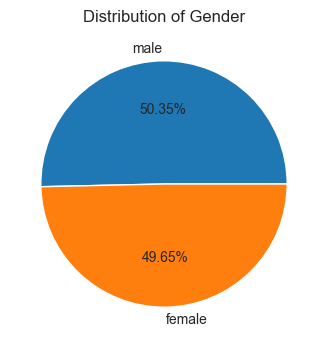

In [27]:
# Univariate analysis of categorical column (Gender).
fig = plt.figure(figsize=(4,4))

plt.pie(df['Gender'].value_counts(), labels=df['Gender'].unique(), autopct="%.2f%%")
plt.title("Distribution of Gender")
plt.show()

- ###  The Gender is evenly distributed between Male and Female in the dataset. &#8593;

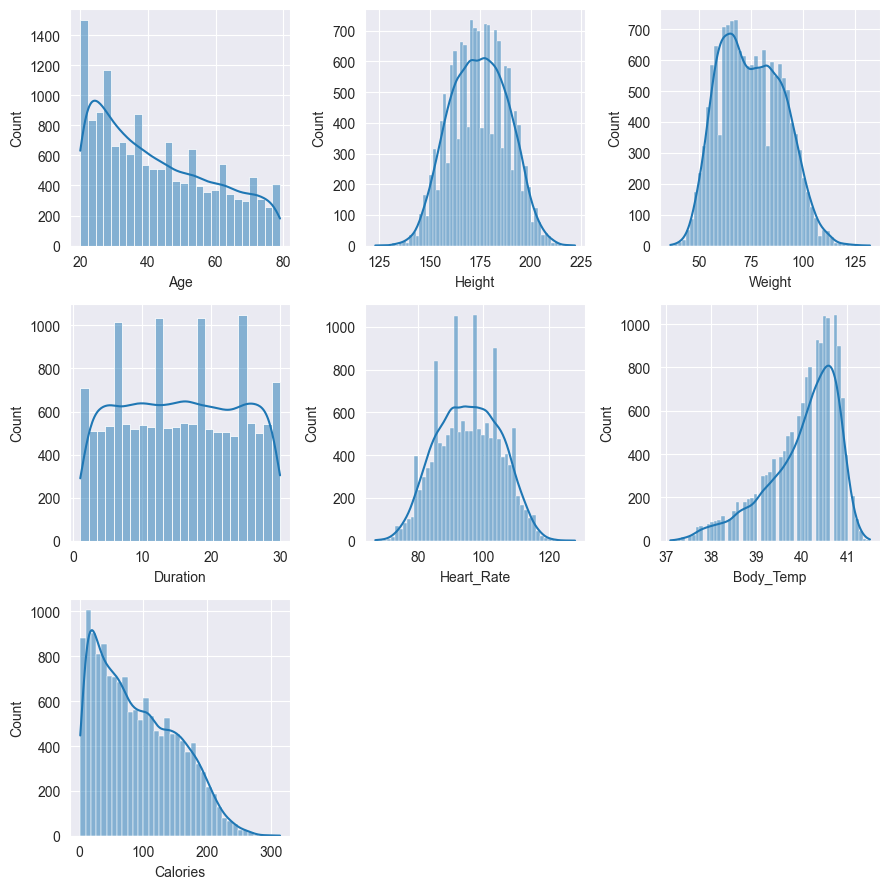

In [28]:
# All-in-one numerical univariate analysis. (HISTOGRAM + KDE)

cols, rows = 3,3
num_col = df.select_dtypes(exclude='object').columns

fig = plt.figure(figsize=(cols*3, rows*3))

for i, col in enumerate(num_col):
    ax = fig.add_subplot(rows, cols, i+1)
    sns.histplot(x=df[col], ax=ax, kde=True)

fig.tight_layout()
plt.show()

- ### The histograms infer the following: &#8593;
    - #### Height, Weight & Heart_Rate are Normally distributed (Gaussian Distribution).
    - #### Age & Calories are postively skewed (Right skewed)
    - #### Body_Temp is negatively skewed (left skewed).

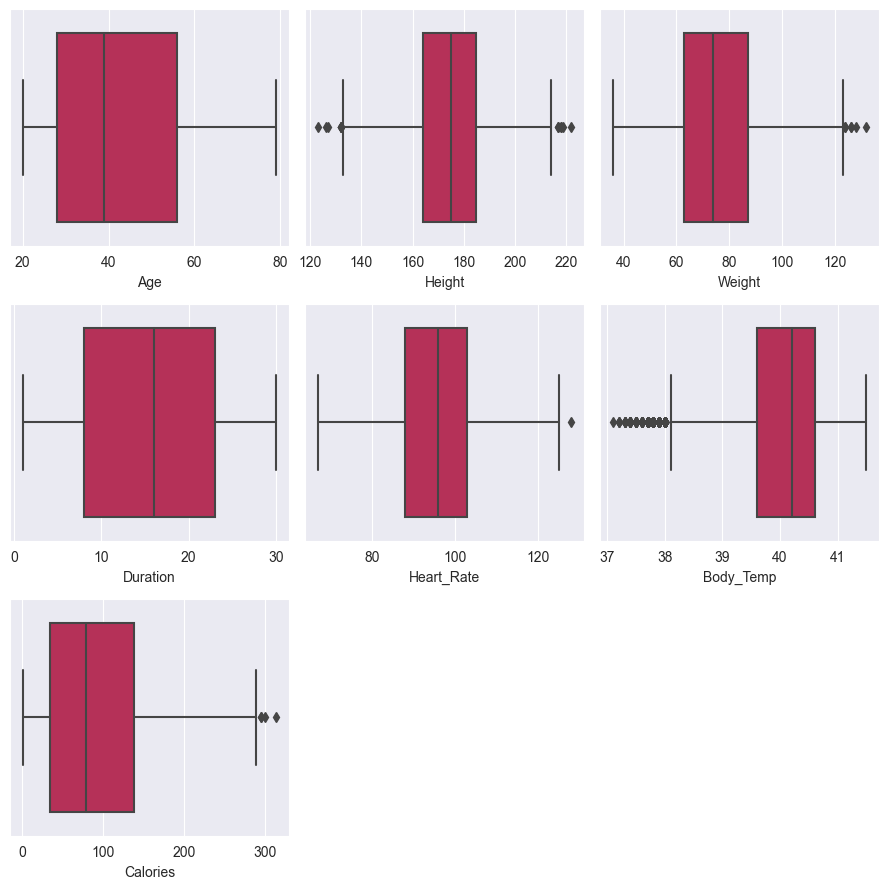

In [29]:
# All-in-one numerical univariate analysis. (BOXPLOT)

cols, rows = 3,3
num_col = df.select_dtypes(exclude='object').columns

fig = plt.figure(figsize=(cols*3, rows*3))

for i, col in enumerate(num_col):
    ax = fig.add_subplot(rows, cols, i+1)
    sns.boxplot(x=df[col], ax=ax, palette='rocket')

fig.tight_layout()
plt.show()

- ### Height, Weight, Heart_Rate, Body_Temp & Calories columns contain possible outliers. &#8593;

# Bivariate & Multivariate Analysis

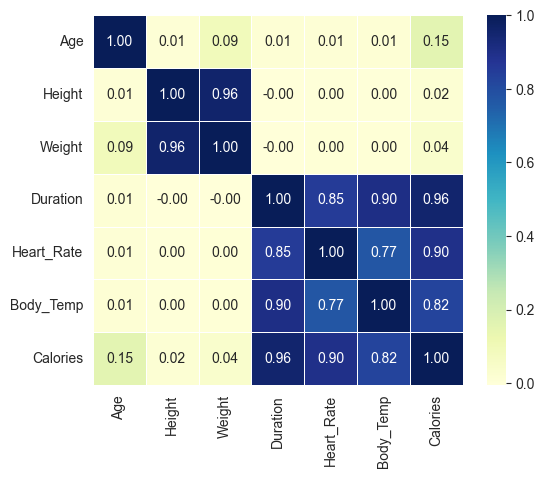

In [30]:
# Correlation heatmap
fig = plt.figure()

num_cols = df.select_dtypes(exclude='object')

sns.heatmap(num_cols.corr(), annot= True, square= True, cmap= "YlGnBu", fmt= ".2f", linewidths= .5)
plt.show()

- ### Positive correlation between Height & Weight. Also, Duration, Heart_Rate, Body_Temp & Calories exhibit strong correlation between them. &#8593;

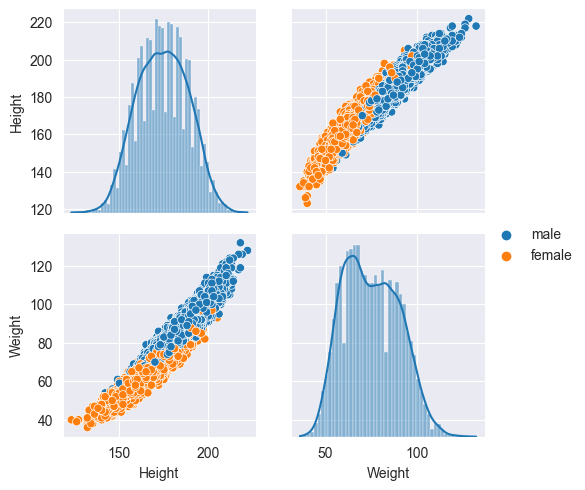

In [31]:
# Correlation between height and weight
new_df = df[['Height', 'Weight']]

g = sns.PairGrid(new_df)
g.map_diag(sns.histplot, kde=True)
g.map_offdiag(sns.scatterplot, hue= df['Gender'])
g.add_legend()

- ### Normal Distribution, Positive Correlation and Linear plot. &#8593;

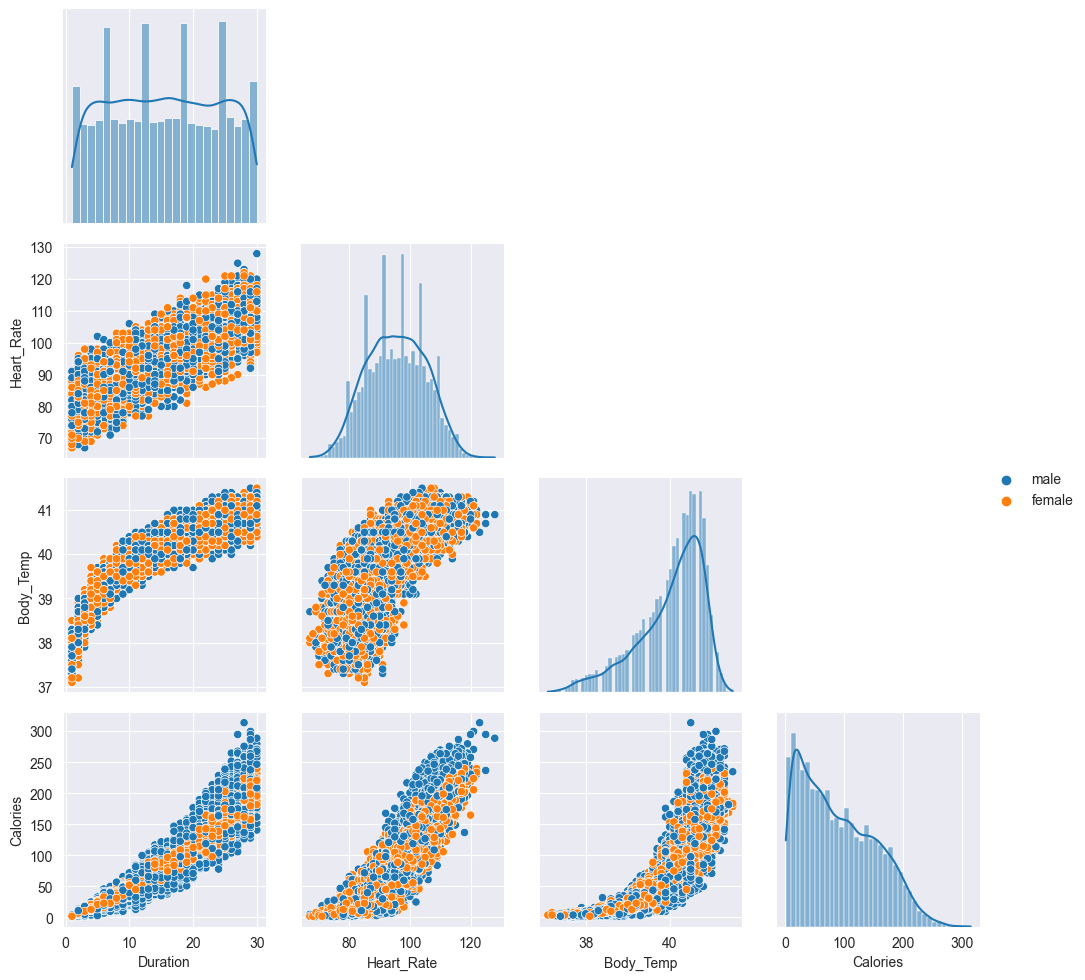

In [32]:
# Correlation among all other numerical columns
new_df = df[['Duration', 'Heart_Rate', 'Body_Temp', 'Calories']]

g = sns.PairGrid(new_df, corner=True)
g.map_diag(sns.histplot, kde=True)
g.map_lower(sns.scatterplot, hue= df['Gender'])
g.add_legend()

# Feature Engineering

##### Converting text in 'Gender' column to numerical. Here, male: 0 and female: 1

In [33]:
# Convert text to numeric in 'Gender' column.
# Here male: 0 , female: 1
df.replace({'Gender': {'male': 0, 'female': 1}}, inplace=True)

##### Height and Weight are strongly correlated to each other. Instead of removing a column, let's combine them to give BMI.

In [34]:
# creating a new column bmi from height and weight
df['h'] = df['Height']/100
df['h_squared'] = df['h']*df['h']
df['bmi'] = df['Weight'] / df['h_squared']
df['bmi'] = df['bmi'].round(decimals=2)

# remove redundant columns
df.drop(['Height', 'Weight', 'h', 'h_squared'], axis= 1, inplace=True)

##### Defining a function to pick features with high correlation. Here, the threshold is 80%.

In [35]:
def correlation(df, threshold):
    correlated_cols = set()
    corr_matrix = df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                colname = corr_matrix.columns[i]
                correlated_cols.add(colname)
    return correlated_cols

correlation(df, 0.8)

{'Body_Temp', 'Calories', 'Heart_Rate'}

##### 'Calories' is our dependant/Output Variable. Removing Body_Temp & Heart_Rate.

In [36]:
df.drop(['Body_Temp', 'Heart_Rate'], axis=1, inplace=True)

# Model Training

##### Splitting Data

In [37]:
# Splitting Data
X = df.drop('Calories', axis=1)
y = df['Calories']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(12000, 4) (3000, 4) (12000,) (3000,)


##### Linear Regression

In [38]:
lr = LinearRegression()
lr.fit(X_train, y_train)

pred = lr.predict(X_test)
rmse = mean_squared_error(y_test, pred, squared=False)
r2 = r2_score(y_test, pred)
print(f'Linear Regression\nRMSE: {rmse:.5f}, r2 score: {r2:.5f}')


Linear Regression
RMSE: 16.33373, r2 score: 0.93389


##### KNeighborsRegressor

In [39]:
knn = KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski')
knn.fit(X_train, y_train)

pred = knn.predict(X_test)
rmse = mean_squared_error(y_test, pred, squared=False)
r2 = r2_score(y_test, pred)
print(f'KNN\nRMSE: {rmse:.5f}, r2 score: {r2:.5f}')

KNN
RMSE: 13.61790, r2 score: 0.95405


##### Decision Tree

In [40]:
dt = DecisionTreeRegressor(criterion='friedman_mse', splitter='best', random_state=42)
dt.fit(X_train, y_train)

pred = dt.predict(X_test)
rmse = mean_squared_error(y_test, pred, squared=False)
r2 = r2_score(y_test, pred)
print(f'Decision Tree\nRMSE: {rmse:.5f}, r2 score: {r2:.5f}')

Decision Tree
RMSE: 17.56039, r2 score: 0.92359


##### Support Vector Regressor

In [41]:
svm = SVR(kernel="poly", degree=5, gamma='scale', coef0=0.1, tol=1e-3, C=1.0, epsilon=0.1, max_iter=-1)
svm.fit(X_train, y_train)

pred = svm.predict(X_test)
rmse = mean_squared_error(y_test, pred, squared=False)
r2 = r2_score(y_test, pred)
print(f'SVR\nRMSE: {rmse:.5f}, r2 score: {r2:.5f}')

SVR
RMSE: 13.35129, r2 score: 0.95583


##### GradientBoost Regressor

In [42]:
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train.values, y_train)

pred = gb.predict(X_test.values)
rmse = mean_squared_error(y_test, pred, squared=False)
R2 = r2_score(y_test, pred)
print(f"Gradient Boost Machine\nRMSE: {rmse:.5f}, R2 Score: {R2:.5f}")

Gradient Boost Machine
RMSE: 12.03519, R2 Score: 0.96411


##### XGBoost Regressor

In [43]:
xgb = XGBRFRegressor()
xgb.fit(X_train, y_train)

pred = xgb.predict(X_test)
rmse = mean_squared_error(y_test, pred, squared=False)
R2 = r2_score(y_test, pred)
print(f"XGBoost\nRMSE: {rmse:.5f}, R2 Score: {R2:.5f}")

XGBoost
RMSE: 12.69596, R2 Score: 0.96006


In [44]:
pickle.dump(gb, open('model.pkl', 'wb'))